In [1]:
from __future__ import print_function, division
import scipy


import keras
from keras.datasets import mnist
#from keras_contrib.layers.normalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import datetime
import matplotlib.pyplot as plt
import sys
from data_loader import DataLoader
import numpy as np
import os
from glob import glob

Using Theano backend.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Using cuDNN version 5110 on context None
Mapped name None to device cuda: TITAN X (Pascal) (0000:01:00.0)


In [2]:

def gen_data(f_mean_shift=(2,3), fvar=2, g_mean_shift=(-1,-1), gvar=0.5, num_pts=1000, mean=(0,0), var=1.0, batch_size=1):
        #data_type = "train%s" % domain if not is_testing else "test%s" % domain
        cov=var*np.eye(2)
        orig = np.random.multivariate_normal(mean, cov, num_pts)
        fmean=np.asarray(mean)+np.asarray(f_mean_shift)
        fpts= np.random.multivariate_normal(fmean, fvar*cov, num_pts)
        gmean=np.asarray(mean)+np.asarray(g_mean_shift)
        gpts=np.random.multivariate_normal(gmean, gvar*cov, num_pts)

        return orig, fpts, gpts
    #where should I actually get this data? Does here work?
orig, data_A, data_B=gen_data((10,10), 3, (-7,6), .25, 1000)



In [3]:

class CycleGAN():
    def __init__(self, data_A, data_B):
        
        #
        self.data_shape=(2,)
        self.dataset_name = 'apple2orange'
        self.data_dim=2

        # Loss weights
        self.lambda_cycle = 10.0                    # Cycle-consistency loss
        self.lambda_id = 0.01 * self.lambda_cycle    # Identity loss

        #does this optimizer make sense for non-image data?
        #learning rate, decay rate
        optimizer = Adam(0.001, 0.7)

        #does MSE make sense with non-image data?
        # Build and compile the discriminators
        self.d_A = self.build_discriminator()
        self.d_B = self.build_discriminator()
        self.d_A.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])
        self.d_B.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

        #-------------------------
        # Construct Computational
        #   Graph of Generators
        #-------------------------

        # Build the generators
        self.g_AB = self.build_generator()
        self.g_BA = self.build_generator()

        # Input instances from both domains
        datum_A = Input(shape=self.data_shape)
        datum_B = Input(shape=self.data_shape)


        #Is this going to work the way I have it here
        #or should I be taking something from a batch?
        # Translate images to the other domain
        fake_B = self.g_AB(datum_A)
        fake_A = self.g_BA(datum_B)
        # Translate images back to original domain
        reconstr_A = self.g_BA(fake_B)
        reconstr_B = self.g_AB(fake_A)
        # Identity mapping of images
        datum_A_id = self.g_BA(datum_A)
        datum_B_id = self.g_AB(datum_B)

        # For the combined model we will only train the generators
        self.d_A.trainable = False
        self.d_B.trainable = False

        # Discriminators determines validity of translated images
        valid_A = self.d_A(fake_A)
        valid_B = self.d_B(fake_B)

        # Combined model trains generators to fool discriminators
        self.combined = Model(inputs=[datum_A, datum_B],
                              outputs=[ valid_A, valid_B,
                                        reconstr_A, reconstr_B,
                                        datum_A_id, datum_B_id ])
        self.combined.compile(loss=['mse', 'mse',
                                    'mae', 'mae',
                                    'mae', 'mae'],
                            loss_weights=[  1, 1,
                                            self.lambda_cycle, self.lambda_cycle,
                                            self.lambda_id, self.lambda_id ],
                            optimizer=optimizer)

    

    def build_generator(self):
        """
        Simple MLP generator for the MoG unrolled GAN toy experiment
        """

        gen_input = Input(shape=(self.data_dim,), name="generator_input")

        x = Dense(2*self.data_dim)(gen_input)
        x = Activation("relu")(x)
     #     for i in range(2):
        x = Dense(2*self.data_dim)(x)
        x = Activation("relu")(x)
        x = Dense(2)(gen_input)
        

        generator_model = Model(inputs=[gen_input], outputs=[x])
        #visualize_model(generator_model)

        return generator_model

#        
    def build_discriminator(self):

        """
        Simple MLP discriminator for the MoG unrolled GAN toy experiment
        """

        disc_input = Input(shape=(2,), name="discriminator_input")

        x = Dense(2*self.data_dim)(disc_input)
        x = Activation("tanh")(x)
    #     for i in range(2):
        x = Dense(2*self.data_dim)(x)
        x = Activation("tanh")(x)
        x = Dense(1)(x)
        x = Activation("sigmoid")(x)

        discriminator_model = Model(inputs=[disc_input], outputs=[x])
        #visualize_model(discriminator_model)

        #is there a difference between what this returns and the original cycelgan does?
        return discriminator_model

    
    def train(self, epochs, batch_size=1, sample_interval=50):

        start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((batch_size,)) #+ self.disc_patch)
        fake = np.zeros((batch_size,)) #+ self.disc_patch)
        self.g_AB.summary()
        self.g_BA.summary()
        self.d_A.summary()
        self.d_B.summary()
        self.n_batches = int(min(len(data_A), len(data_B)) / batch_size)
        #total_samples = self.n_batches * batch_size
        for epoch in range(epochs):
            for i in range(self.n_batches-1):
                #randomly shuffle data?
                
                #take the corresponding "Batch size" number of elements
                batch_A = data_A[i*batch_size:(i+1)*batch_size]
                batch_B = data_B[i*batch_size:(i+1)*batch_size]
                #put them through this thing
                
                
                # ----------------------
                #  Train Discriminators
                # ----------------------
               # print(imgs_A.shape)

                # Translate images to opposite domain
                fake_B = self.g_AB.predict(batch_A)
                fake_A = self.g_BA.predict(batch_B)
                #print(fake_A.shape)
                #print(fake_B.shape)
                # Train the discriminators (original images = real / translated = Fake)
                dA_loss_real = self.d_A.train_on_batch(batch_A, valid)
                dA_loss_fake = self.d_A.train_on_batch(fake_A, fake)
                dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

                dB_loss_real = self.d_B.train_on_batch(batch_B, valid)
                dB_loss_fake = self.d_B.train_on_batch(fake_B, fake)
                dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

                # Total disciminator loss
                d_loss = 0.5 * np.add(dA_loss, dB_loss)


                # ------------------
                #  Train Generators
                # ------------------

                # Train the generators
                g_loss = self.combined.train_on_batch([batch_A, batch_B],
                                                        [valid, valid,
                                                        batch_A, batch_B,
                                                        batch_A, batch_B])

                elapsed_time = datetime.datetime.now() - start_time

                # Plot the progress
                print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %05f, adv: %05f, recon: %05f, id: %05f] time: %s " \
                                                                        % ( epoch, epochs,
                                                                            i, self.n_batches,
                                                                            d_loss[0], 100*d_loss[1],
                                                                            g_loss[0],
                                                                            np.mean(g_loss[1:3]),
                                                                            np.mean(g_loss[3:5]),
                                                                            np.mean(g_loss[5:6]),
                                                                            elapsed_time))

                # If at save interval => save generated image samples
                if i % sample_interval == 0:
                    self.sample_data(epoch, i)

    def sample_data(self, epoch, batch_i):
        os.makedirs('images/%s' % self.dataset_name, exist_ok=True)
       # r, c = 2, 3

        orig2, pic_data_A, pic_data_B= gen_data((10,10), 3, (-7,6), .25, 1000)
        
    
        # Translate images to the other domain
        fake_B = self.g_AB.predict(pic_data_A)
        fake_A = self.g_BA.predict(pic_data_B)
        # Translate back to original domain
        reconstr_A = self.g_BA.predict(fake_B)
        reconstr_B = self.g_AB.predict(fake_A)
        
        fig = plt.figure()
        ax1 = fig.add_subplot(131)

        ax1.scatter(pic_data_A[:, 0], pic_data_A[:,1], s=25, c='b', marker="s", label='original')
        ax1.scatter(fake_A[:,0], fake_A[:,1], c='r', s=25, marker="o", label='fake')
        ax1.scatter(reconstr_A[:,0], reconstr_A[:,1], s=25, c='g', marker="o", label='reconstructed')
        plt.legend(loc='upper left');
        
        ax2=fig.add_subplot(132)
        ax2.scatter(pic_data_B[:, 0], pic_data_B[:,1], s=25, c='b', marker="s", label='original')
        ax2.scatter(fake_B[:,0], fake_B[:,1], s=25, c='r', marker="o", label='fake')
        ax2.scatter(reconstr_B[:,0], reconstr_B[:,1], s=25, c='g', marker="o", label='reconstructed')
        plt.legend(loc='upper left');
        
        ax3=fig.add_subplot(133)
        ax3.scatter(pic_data_B[:, 0], pic_data_B[:,1], s=25, c='b', marker="s", label='originalB')
        ax3.scatter(fake_B[:,0], fake_B[:,1], s=25, c='r', marker="o", label='fakeB')
        ax3.scatter(reconstr_B[:,0], reconstr_B[:,1], s=25, c='g', marker="o", label='reconstructedB')
        ax3.scatter(pic_data_A[:, 0], pic_data_A[:,1], s=25, c='b', marker="s", label='originalA')
        ax3.scatter(fake_A[:,0], fake_A[:,1], c='r', s=25, marker="o", label='fakeA')
        ax3.scatter(reconstr_A[:,0], reconstr_A[:,1], s=25, c='g', marker="o", label='reconstructedA')
        plt.legend(loc='upper left');
        
        plt.show()
        plt.clf()
        fig.savefig("images/%s/%d_%d.png" % (self.dataset_name, epoch, batch_i))
        plt.close()

In [ ]:
if __name__ == '__main__':
    gan = CycleGAN(data_A, data_B)
    gan.train(epochs=200, batch_size=10, sample_interval=20)



In [3]:
class CycleGAN2():
    def __init__(self, data_A, data_B, lr=.0002):
        
        #
        self.data_shape=(2,)
        self.dataset_name = 'apple2orange'
        self.data_dim=2

        # Loss weights
        self.lambda_cycle = 10.0                    # Cycle-consistency loss
        self.lambda_id = 0.01 * self.lambda_cycle    # Identity loss

        optimizer = Adam(lr, 0.5)

        # Build and compile the discriminators
        self.d_A = self.build_discriminator()
        self.d_B = self.build_discriminator()
        self.d_A.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])
        self.d_B.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

        #-------------------------
        # Construct Computational
        #   Graph of Generators
        #-------------------------

        # Build the generators
        self.g_AB = self.build_generator()
        self.g_BA = self.build_generator()

        # Input instances from both domains
        datum_A = Input(shape=self.data_shape)
        datum_B = Input(shape=self.data_shape)


        #Is this going to work the way I have it here
        #or should I be taking something from a batch?
        # Translate images to the other domain
        fake_B = self.g_AB(datum_A)
        fake_A = self.g_BA(datum_B)
        # Translate images back to original domain
        reconstr_A = self.g_BA(fake_B)
        reconstr_B = self.g_AB(fake_A)
        # Identity mapping of images
        datum_A_id = self.g_BA(datum_A)
        datum_B_id = self.g_AB(datum_B)

        # For the combined model we will only train the generators
        self.d_A.trainable = False
        self.d_B.trainable = False

        # Discriminators determines validity of translated images
        valid_A = self.d_A(fake_A)
        valid_B = self.d_B(fake_B)

        # Combined model trains generators to fool discriminators
        self.combined = Model(inputs=[datum_A, datum_B],
                              outputs=[ valid_A, valid_B,
                                        reconstr_A, reconstr_B,
                                        datum_A_id, datum_B_id ])
        self.combined.compile(loss=['mse', 'mse',
                                    'mae', 'mae',
                                    'mae', 'mae'],
                            loss_weights=[  50, 50,
                                            self.lambda_cycle, self.lambda_cycle,
                                            self.lambda_id, self.lambda_id ],
                            optimizer=optimizer)

    

    def build_generator(self):
        """
        Simple MLP generator for the MoG unrolled GAN toy experiment
        """

        gen_input = Input(shape=(self.data_dim,), name="generator_input")

        x = Dense(2*self.data_dim)(gen_input)
        x = Activation("relu")(x)
     #     for i in range(2):
        x = Dense(2*self.data_dim)(x)
        x = Activation("relu")(x)
        x = Dense(2)(gen_input)
        

        generator_model = Model(inputs=[gen_input], outputs=[x])
        #visualize_model(generator_model)

        return generator_model

        
#         gen_input = Input(shape=(self.data_dim,), name="generator_input")

#         x = Dense(4*self.data_dim)(gen_input)
#         x = LeakyReLU(0.2)(x)
#         x = Dropout(0.25)(x)
#         x = Dense(2*self.data_dim)(x)
#         x = LeakyReLU(0.2)(x)
#         x = Dense(self.data_dim, activation='linear')(x)
        
#         generator_model = Model(inputs=[gen_input], outputs=[x])
#         #visualize_model(generator_model)
#         print("GENERATOR")
#         #model.summary()
#         return generator_model
        
#        
    def build_discriminator(self):

        """
        Simple MLP discriminator for the MoG unrolled GAN toy experiment
        """

        #disc_input = Input(shape=(2,), name="discriminator_input")
        
        
        disc_input = Input(shape=(2,), name="discriminator_input")

        x = Dense(2*self.data_dim)(disc_input)
        x = Activation("tanh")(x)
    #     for i in range(2):
        x = Dense(2*self.data_dim)(x)
        x = Activation("tanh")(x)
        x = Dense(1)(x)
        x = Activation("sigmoid")(x)

        discriminator_model = Model(inputs=[disc_input], outputs=[x])
        #visualize_model(discriminator_model)

        #is there a difference between what this returns and the original cycelgan does?
        return discriminator_model
        
#         model = Sequential()
#         model.add(Dense(4*self.data_dim))#(disc_input))
#         model.add(Activation('relu'))
#         #model.add(Dropout(0.25))
#         model.add(Dense(2*self.data_dim))
#         model.add(Activation('relu'))
#         model.add(Dense(1))
#         model.add(Activation("sigmoid"))

#         discriminator_model = model #Model(inputs=[disc_input], outputs=[x])
#         #visualize_model(discriminator_model)
#         print("DISCRIMINATOR")
#         #model.summary()
#         #is there a difference between what this returns and the original cycelgan does?
#         return discriminator_model
    
    def train(self, epochs, batch_size=1, sample_interval=50):

        start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((batch_size,)) #+ self.disc_patch)
        fake = np.zeros((batch_size,)) #+ self.disc_patch)
        self.g_AB.summary()
        self.g_BA.summary()
        self.d_A.summary()
        self.d_B.summary()
        self.n_batches = int(min(len(data_A), len(data_B)) / batch_size)
        #total_samples = self.n_batches * batch_size
        for epoch in range(epochs):
            for i in range(self.n_batches-1):
                #randomly shuffle data?
                
                #take the corresponding "Batch size" number of elements
                batch_A = data_A[i*batch_size:(i+1)*batch_size]
                batch_B = data_B[i*batch_size:(i+1)*batch_size]
                #put them through this thing
                
                
                # ----------------------
                #  Train Discriminators
                # ----------------------
               # print(imgs_A.shape)

                # Translate images to opposite domain
                fake_B = self.g_AB.predict(batch_A)
                fake_A = self.g_BA.predict(batch_B)
                #print(fake_A.shape)
                #print(fake_B.shape)
                # Train the discriminators (original images = real / translated = Fake)
                dA_loss_real = self.d_A.train_on_batch(batch_A, valid)
                dA_loss_fake = self.d_A.train_on_batch(fake_A, fake)
                dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

                dB_loss_real = self.d_B.train_on_batch(batch_B, valid)
                dB_loss_fake = self.d_B.train_on_batch(fake_B, fake)
                dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

                # Total disciminator loss
                d_loss = 0.5 * np.add(dA_loss, dB_loss)


                # ------------------
                #  Train Generators
                # ------------------

                # Train the generators
                g_loss = self.combined.train_on_batch([batch_A, batch_B],
                                                        [valid, valid,
                                                        batch_A, batch_B,
                                                        batch_A, batch_B])

                elapsed_time = datetime.datetime.now() - start_time

                # Plot the progress
                print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %05f, adv: %05f, recon: %05f, id: %05f] time: %s " \
                                                                        % ( epoch, epochs,
                                                                            i, self.n_batches,
                                                                            d_loss[0], 100*d_loss[1],
                                                                            g_loss[0],
                                                                            np.mean(g_loss[1:3]),
                                                                            np.mean(g_loss[3:5]),
                                                                            np.mean(g_loss[5:6]),
                                                                            elapsed_time))

                # If at save interval => save generated image samples
                if i % sample_interval == 0:
                    self.sample_data(epoch, i)

    def sample_data(self, epoch, batch_i):
        os.makedirs('images/%s' % self.dataset_name, exist_ok=True)
       # r, c = 2, 3

        orig2, pic_data_A, pic_data_B= gen_data()
        
    
        # Translate images to the other domain
        fake_B = self.g_AB.predict(pic_data_A)
        fake_A = self.g_BA.predict(pic_data_B)
        # Translate back to original domain
        reconstr_A = self.g_BA.predict(fake_B)
        reconstr_B = self.g_AB.predict(fake_A)
        
        fig = plt.figure()
        ax1 = fig.add_subplot(131)

        ax1.scatter(pic_data_A[:, 0], pic_data_A[:,1], s=25, c='b', marker="s", label='original')
        ax1.scatter(fake_A[:,0], fake_A[:,1], c='r', s=25, marker="o", label='fake')
        ax1.scatter(reconstr_A[:,0], reconstr_A[:,1], s=25, c='g', marker="o", label='reconstructed')
        plt.legend(loc='upper left');
        
        ax2=fig.add_subplot(132)
        ax2.scatter(pic_data_B[:, 0], pic_data_B[:,1], s=25, c='b', marker="s", label='original')
        ax2.scatter(fake_B[:,0], fake_B[:,1], s=25, c='r', marker="o", label='fake')
        ax2.scatter(reconstr_B[:,0], reconstr_B[:,1], s=25, c='g', marker="o", label='reconstructed')
        plt.legend(loc='upper left');
        
        ax3=fig.add_subplot(133)
        ax3.scatter(pic_data_B[:, 0], pic_data_B[:,1], s=25, c='b', marker="s", label='originalB')
        ax3.scatter(fake_B[:,0], fake_B[:,1], s=25, c='r', marker="o", label='fakeB')
        ax3.scatter(reconstr_B[:,0], reconstr_B[:,1], s=25, c='g', marker="o", label='reconstructedB')
        ax3.scatter(pic_data_A[:, 0], pic_data_A[:,1], s=25, c='b', marker="s", label='originalA')
        ax3.scatter(fake_A[:,0], fake_A[:,1], c='r', s=25, marker="o", label='fakeA')
        ax3.scatter(reconstr_A[:,0], reconstr_A[:,1], s=25, c='g', marker="o", label='reconstructedA')
        plt.legend(loc='upper left');
        
        plt.show()
        plt.clf()
        fig.savefig("images/%s/%d_%d.png" % (self.dataset_name, epoch, batch_i))
        plt.close()

First Cell where I changed the learning rate, 5x slower

In [ ]:
if __name__ == '__main__':
    gan = CycleGAN2(data_A, data_B)
    gan.train(epochs=400, batch_size=10, sample_interval=20)



bigger discriminator loss

In [ ]:
gan_lr0002_400epochs_50discloss = CycleGAN2(data_A, data_B)
gan_lr0002_400epochs_50discloss.train(epochs=400, batch_size=10, sample_interval=20)

In [6]:
scipy.misc.imread

<function numpy.lib.utils._Deprecate.__call__.<locals>.newfunc(*args, **kwds)>

In [7]:
keras.__version__

'2.2.4'

In [ ]:
gan_lr0002_400epochs_50discloss = CycleGAN2(data_A, data_B)
gan_lr0002_400epochs_50discloss.train(epochs=400, batch_size=10, sample_interval=20)



In [8]:
import tensorflow as tf

In [9]:
tf.__version__

'1.0.1'

In [ ]:
#transpose images to 

In [11]:
o, a, b =gen_data((10,10), 3, (-7,6), .25, 1000)

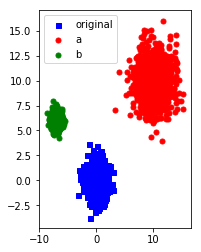

In [12]:
fig = plt.figure()
ax1 = fig.add_subplot(121)

ax1.scatter(o[:, 0], o[:,1], s=25, c='b', marker="s", label='original')
ax1.scatter(a[:,0], a[:,1], c='r', s=25, marker="o", label='a')
ax1.scatter(b[:,0], b[:,1], s=25, c='g', marker="o", label='b')
plt.legend(loc='upper left');
plt.show() 

In [1]:
grid=np.meshgrid(range(-10,10), range(-30,10))
gridreal= np.array([[grid[0].flatten()[i], grid[1].flatten()[i]] for i in range(20*40)])
vals=gan.d_A.predict(gridreal)[:,0]

NameError: name 'np' is not defined

In [ ]:
valid_x = grid[0].flatten()[vals > 0.5]
valid_y = grid[1].flatten()[vals > 0.5]

fake_x = grid[0].flatten()[vals < 0.5]
fake_y = grid[1].flatten()[vals < 0.5]

plt.scatter(valid_x, valid_y)
plt.scatter(fake_x, fake_y)
plt.scatter(data_A[:,0], data_A[:,1])
plt.show()